#### Exploratory Data Analysis

In [34]:
# amount of product each customer purchased?
import pandas as pd
import numpy as np
wholesale = pd.read_csv('wholesale.csv')

In [35]:
wholesale.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


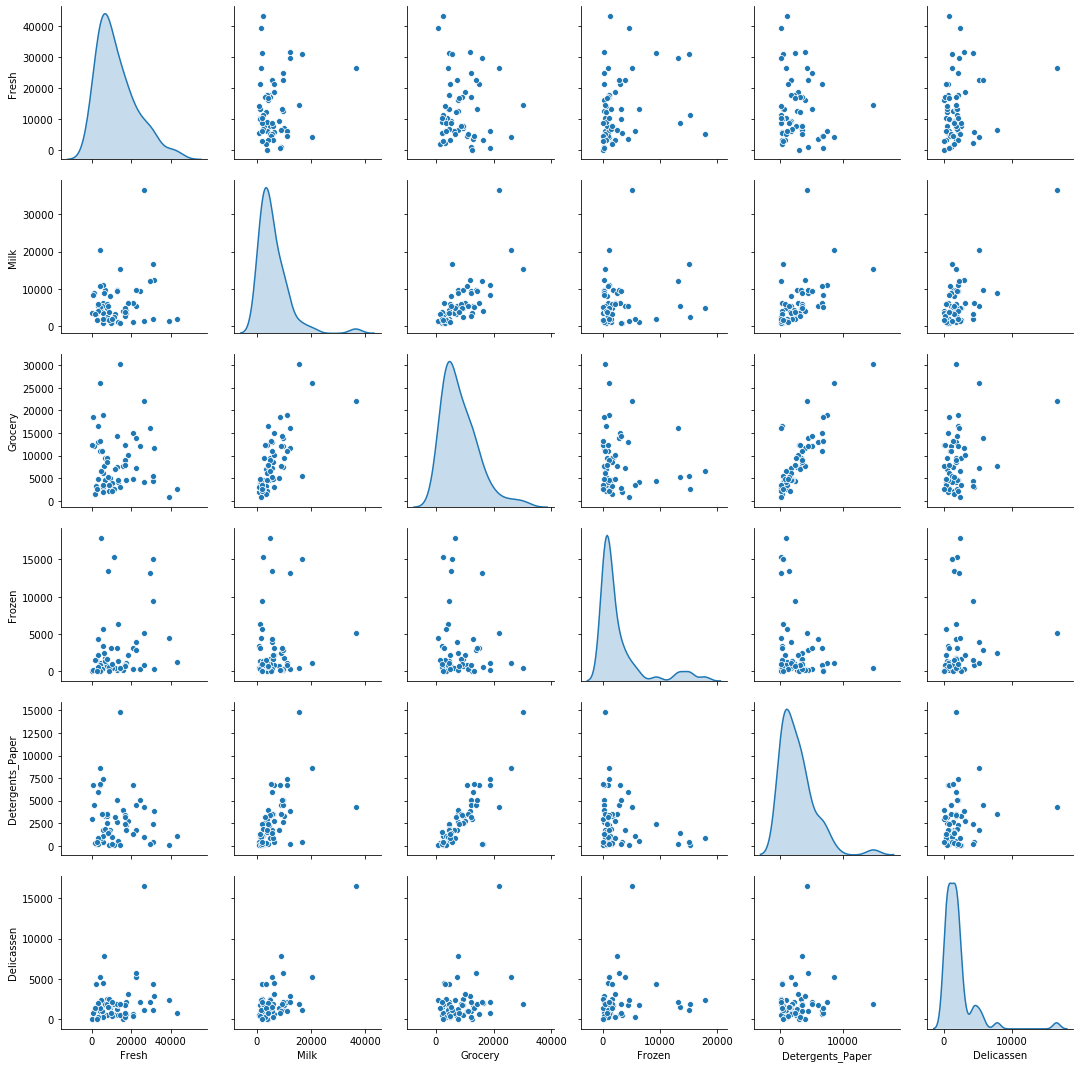

In [36]:
#import seaborn as sns
import seaborn as sns

# Plot the pairwise relationships between the variables
sns.pairplot(wholesale, diag_kind='kde')
plt.show()

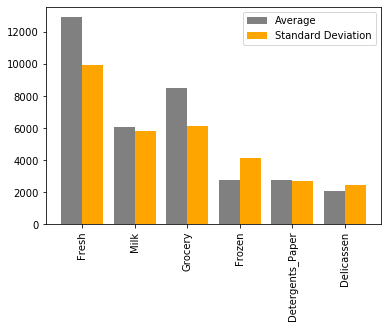

In [37]:
import matplotlib.pyplot as plt

# Get the statistics
averages = wholesale.mean()
std_devs = wholesale.std()
x_names = wholesale.columns
x_ix = np.arange(wholesale.shape[1])

# Create column names list and same length integer list
x_names = wholesale.columns
x_ix = np.arange(wholesale.shape[1])

# Plot the averages data in gray and standard deviations in orange 
plt.bar(x=x_ix-0.2, height=averages, color='grey', label='Average', width=0.4)
plt.bar(x=x_ix+0.2, height=std_devs, color='orange', label='Standard Deviation', width=0.4)

# Add x-axis labels and rotate
plt.xticks(ticks=x_ix, labels=x_names, rotation=90)

# Add the legend and display the chart
plt.legend()
plt.show()

#### Scaling the numbers - Log or Boxcox + StandardScaler

In [38]:
# First option - log transformation
whole_log = np.log(wholesale)

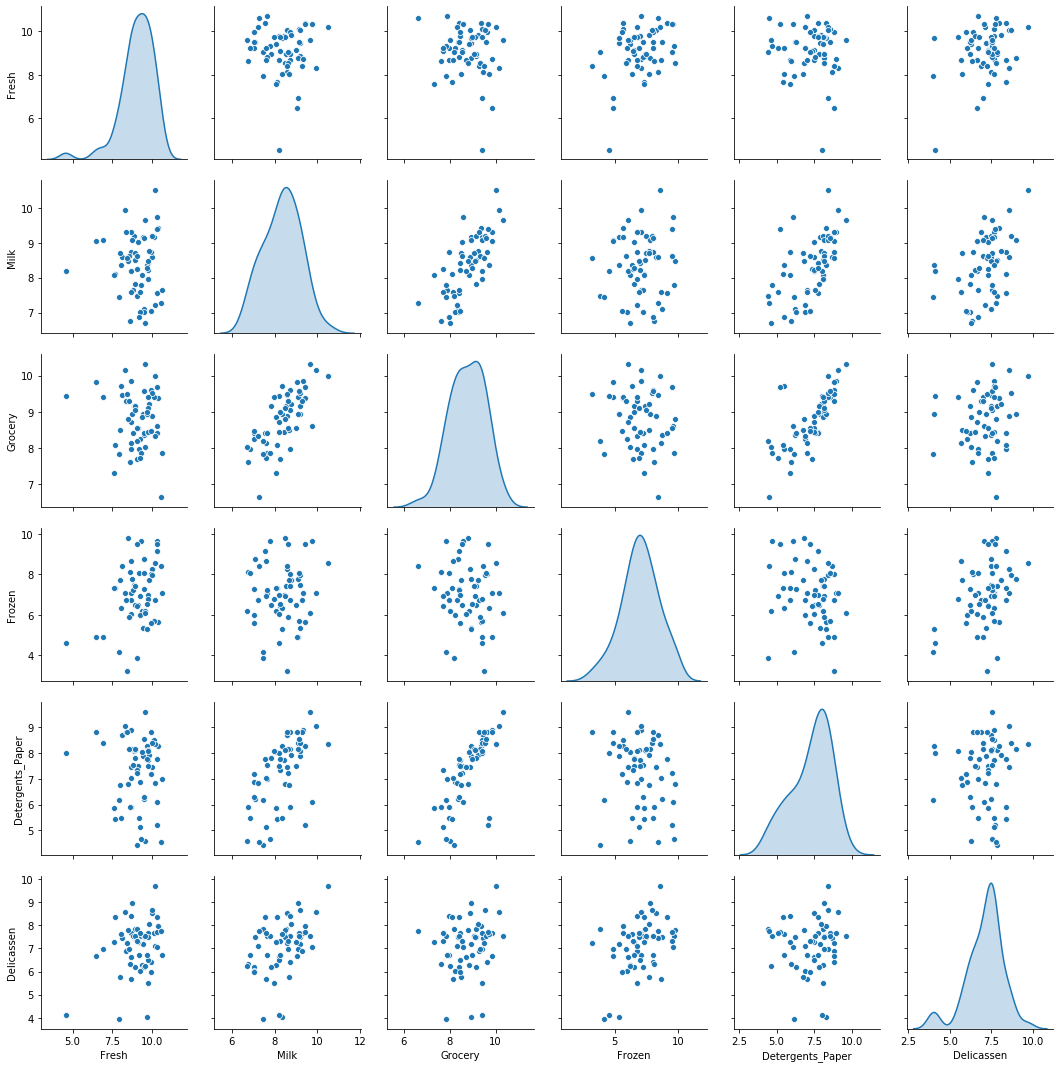

In [39]:
# Plot the pairwise relationships between the variables
sns.pairplot(whole_log, diag_kind='kde')
plt.show()

In [40]:
# Second option - Box-Cox transformation
# A Box Cox transformation is a way to transform non-normal dependent variables into a normal shape.\
# Normality is an important assumption for many statistical techniques; if your data isn't normal,\
# applying a Box-Cox means that you are able to run a broader number of tests.

from scipy import stats

def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return x_boxcox

wholesale_boxcox = wholesale.apply(boxcox_df, axis=0)

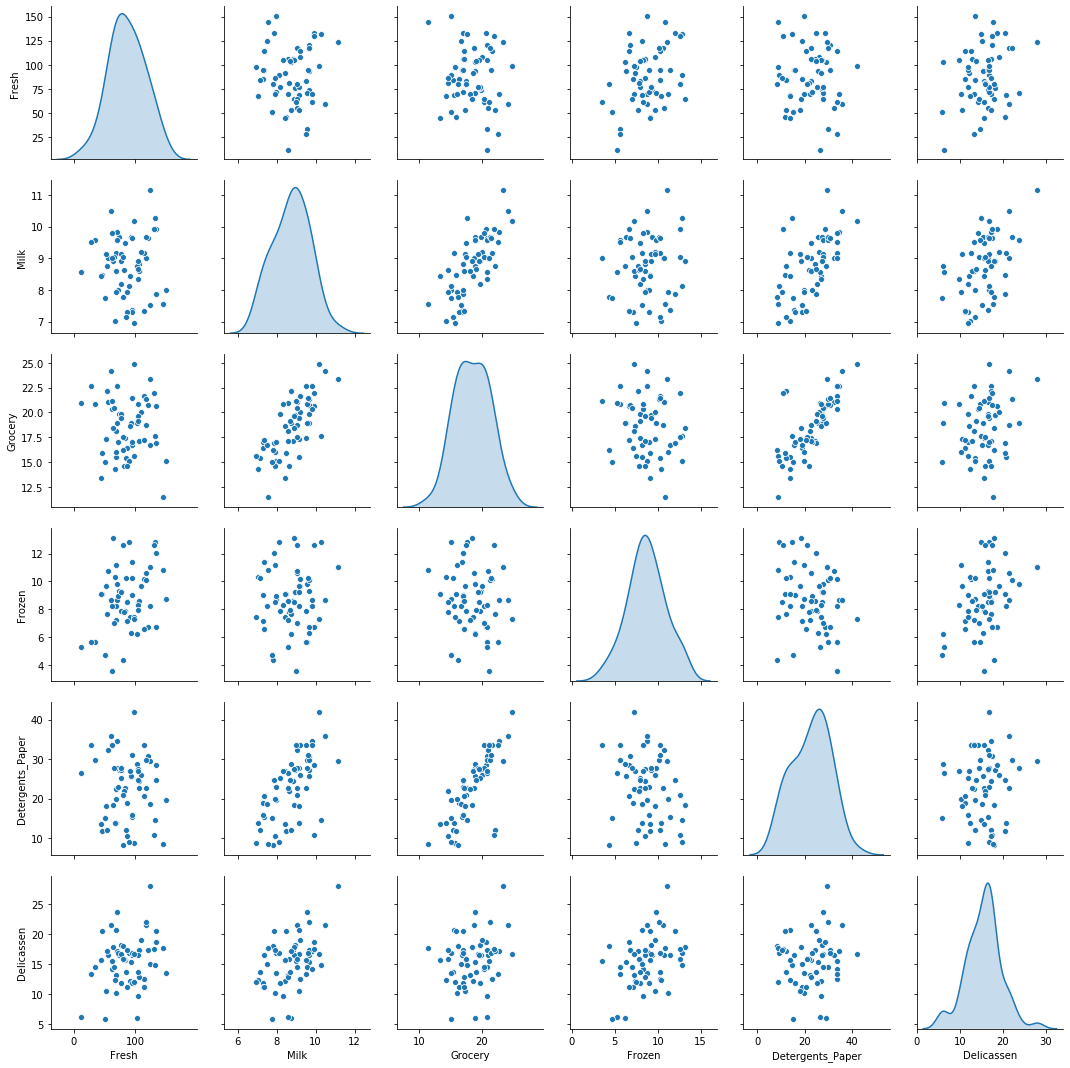

In [41]:
sns.pairplot(wholesale_boxcox, diag_kind='kde')
plt.show()

In [42]:
wholesale_boxcox.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,93.247066,9.662231,18.917617,6.282067,25.625365,15.416535
1,74.096209,9.679764,19.843281,9.329234,27.245656,16.560584
2,71.086285,9.560440,18.980019,9.810864,27.773708,23.683221
3,94.940272,7.374912,16.762573,11.384357,15.371402,16.588546
4,116.919244,9.022420,18.728295,10.582688,22.686437,21.491943


In [43]:
# under the boxcox method, it's still best to standardscale stuff.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(wholesale_boxcox)
wholesale_scaled = scaler.transform(wholesale_boxcox)
wholesale_scaled_df = pd.DataFrame(data=wholesale_scaled,
                                   index=wholesale_boxcox.index,
                                   columns=wholesale_boxcox.columns)
wholesale_scaled_df.agg(['mean','std']).round()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
mean,-0.0,0.0,-0.0,0.0,0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


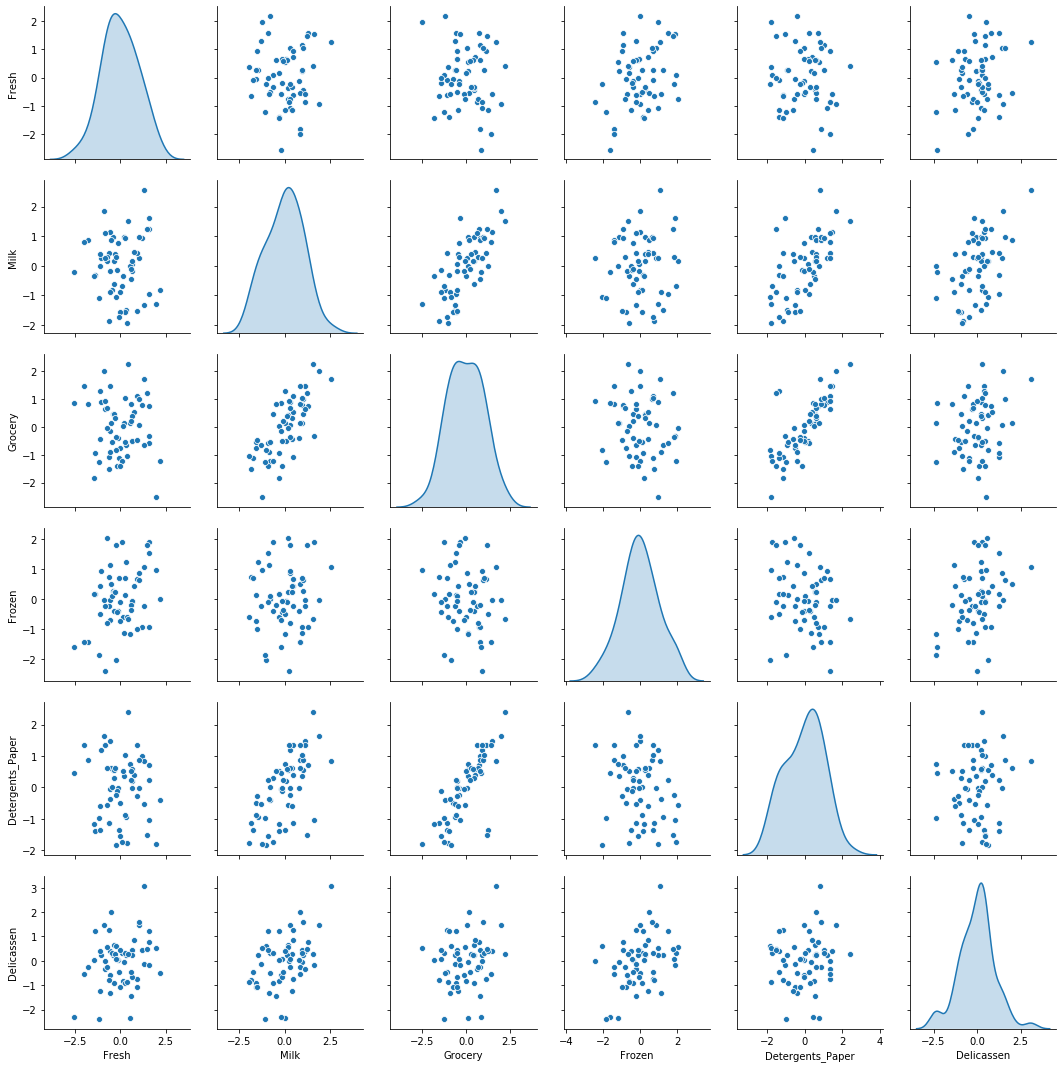

In [45]:
sns.pairplot(wholesale_scaled_df, diag_kind='kde')
plt.show()

#### Kmeans clustering

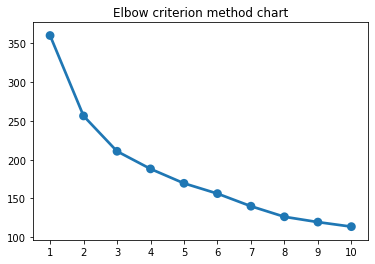

In [49]:
from sklearn.cluster import KMeans
# Create empty sse dictionary
sse = {}

# Fit KMeans algorithm on k values between 1 and 11, sort of like hyptertuning
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=333)
    kmeans.fit(wholesale_scaled_df)
    sse[k] = kmeans.inertia_

# Add the title to the plot
plt.title('Elbow criterion method chart')

# Create and display a scatter plot
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

#### We can see that the elbow plot shows that sse(Residual sum of squares) starts to flatten out after the 3rd and 4th cluster, thus we can conclude n=4 is the best cluster size.

In [65]:
# Initialize `KMeans` with 3 clusters
kmeans=KMeans(n_clusters=3, random_state=123)

# Fit the model on the pre-processed dataset
kmeans.fit(wholesale_scaled_df)

# Assign the generated labels to a new column
wholesale_kmeans3 = wholesale.assign(segment = kmeans.labels_)

In [66]:
wholesale_kmeans3.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,segment
0,12669,9656,7561,214,2674,1338,2
1,7057,9810,9568,1762,3293,1776,1
2,6353,8808,7684,2405,3516,7844,1
3,13265,1196,4221,6404,507,1788,0
4,22615,5410,7198,3915,1777,5185,1


           Fresh     Milk  Grocery  Frozen  Detergents_Paper  Delicassen
segment                                                                 
0        14072.0   2471.0   3526.0  3874.0             868.0      1707.0
1        16609.0  11103.0  13687.0  3418.0            4665.0      3599.0
2         7203.0   5459.0   9728.0   509.0            3191.0       797.0


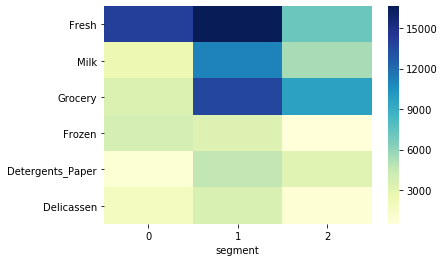

In [68]:
# Group by the segment label and calculate average column values
kmeans3_averages = wholesale_kmeans3.groupby(['segment']).mean().round(0)

# Print the average column values per each segment
print(kmeans3_averages)

# Create a heatmap on the average column values per each segment
sns.heatmap(kmeans3_averages.T, cmap='YlGnBu')

# Display the chart
plt.show()

#### Group 0 only likes fresh category, doesn't care about the other items, Group 1 has a heavy emphasis on Fresh, Milk and Grocery items, Group 2 cares mostly about grocery and fresh items.

#### Alternative segmentation with NMF 

In [73]:
# Import the non-negative matrix factorization module
from sklearn.decomposition import NMF

# Initialize NMF instance with 3 components
nmf = NMF(3)

# Fit the model on the wholesale sales data
nmf.fit(wholesale)

# Extract the components 
components = pd.DataFrame(data=nmf.components_, columns=wholesale.columns)

In [74]:
components

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,365.697410,0.000000,10.900719,0.000000,0.000000,6.708840
1,0.363547,164.022080,244.965307,0.000000,88.433228,40.440009
2,0.000000,120.296129,24.357752,216.914147,0.000000,52.250680


In [75]:
# Create the W matrix
W = pd.DataFrame(data=nmf.transform(wholesale), columns=components.index)
W.index = wholesale.index

# Assign the column name where the corresponding value is the largest
wholesale_nmf3 = wholesale.assign(segment = W.idxmax(axis=1))

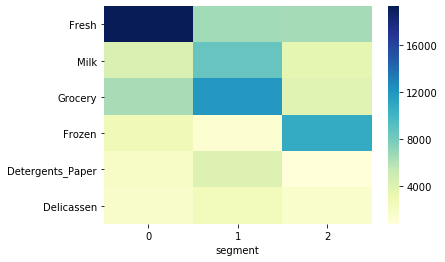

In [77]:
# Calculate the average column values per each segment
nmf3_averages = wholesale_nmf3.groupby('segment').mean().round(0)

# Plot the average values as heatmap
sns.heatmap(nmf3_averages.T, cmap='YlGnBu')

# Display the chart
plt.show()

#### The NMF method comes up with a different segmentation. With Segment 0 being more focused on fresh items, segment 1 being more focused on grocery items and segment 2 focused on frozen items.